In [1]:
import yfinance as yf
from datetime import datetime
from yahoofinancials import YahooFinancials
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from functools import lru_cache
import datasets
from datasets import Dataset, DatasetDict

import pandas as pd
import numpy as np
from functools import partial
from gluonts.time_feature import get_lags_for_frequency
from gluonts.time_feature import time_features_from_frequency_str
from transformers import TimeSeriesTransformerConfig, TimeSeriesTransformerForPrediction
from gluonts.time_feature import (
    time_features_from_frequency_str,
    TimeFeature,
    get_lags_for_frequency,
)
from gluonts.dataset.field_names import FieldName
from gluonts.transform import (
    AddAgeFeature,
    AddObservedValuesIndicator,
    AddTimeFeatures,
    AsNumpyArray,
    Chain,
    ExpectedNumInstanceSampler,
    InstanceSplitter,
    RemoveFields,
    SelectFields,
    SetField,
    TestSplitSampler,
    Transformation,
    ValidationSplitSampler,
    VstackFeatures,
    RenameFields,
)
from transformers import PretrainedConfig
from gluonts.transform.sampler import InstanceSampler
from typing import Optional
from typing import Iterable

import torch
from gluonts.itertools import Cached, Cyclic
from gluonts.dataset.loader import as_stacked_batches
from accelerate import Accelerator
from torch.optim import AdamW
from evaluate import load
from gluonts.time_feature import get_seasonality


d:\Projects\Tradeformers\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_ticker_data(ticker: str, param_start_date, param_end_date) -> dict:
    raw_data = YahooFinancials(ticker)
    return raw_data.get_historical_price_data(param_start_date, param_end_date, "daily").copy()

def fetch_ticker_data(ticker: str, start_date, end_date) -> pd.DataFrame:
    date_range = pd.bdate_range(start=start_date, end=end_date)
    values = pd.DataFrame({'Date': date_range})
    values['Date'] = pd.to_datetime(values['Date'])
    raw_data = get_ticker_data(ticker, start_date, end_date)
    return pd.DataFrame(raw_data[ticker]["prices"])[['date', 'open', 'high', 'low', 'adjclose', 'volume']]

In [3]:
companyName = 'AMZN'
start_date = '2020-04-05'
end_date = '2023-04-05'
stock = fetch_ticker_data(companyName, start_date, end_date)
stock.columns = ['DateTime', 'Open', 'High', 'Low', 'Close', 'Volume']

In [4]:

stock['DateTime'] = stock['DateTime'].apply(lambda x: datetime.fromtimestamp(x))
#stock['DateTime'] = pd.to_datetime(stock['DateTime'])
stock = stock.fillna(method="ffill", axis=0)
stock = stock.fillna(method="bfill", axis=0)
#stock = stock.set_index('DateTime') # use to remove datetime index
#stock.reset_index(inplace=True)     # use to add datetime index
stock.head()

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_7540\293271464.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  stock = stock.fillna(method="ffill", axis=0)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_7540\293271464.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  stock = stock.fillna(method="bfill", axis=0)


,DateTime,Open,High,Low,Close,Volume
0,2020-04-06 20:30:00,96.800003,99.926003,96.500999,99.879501,115464000
1,2020-04-07 20:30:00,100.855499,101.786003,99.880997,100.580002,102280000
2,2020-04-08 20:30:00,101.050003,102.199997,100.557503,102.150002,79546000
3,2020-04-09 20:30:00,102.214996,102.650002,100.883003,102.138000,92930000
4,2020-04-13 20:30:00,102.000000,109.000000,101.900002,108.443497,134334000


In [8]:
type(stock['DateTime'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [6]:
stock.head()

,DateTime,Open,High,Low,Close,Volume
0,2020-04-06 20:30:00,96.800003,99.926003,96.500999,99.879501,115464000
1,2020-04-07 20:30:00,100.855499,101.786003,99.880997,100.580002,102280000
2,2020-04-08 20:30:00,101.050003,102.199997,100.557503,102.150002,79546000
3,2020-04-09 20:30:00,102.214996,102.650002,100.883003,102.138000,92930000
4,2020-04-13 20:30:00,102.000000,109.000000,101.900002,108.443497,134334000


In [203]:
#stock['DateTime'] = stock['DateTime'].dt.date

In [13]:
stock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 755 entries, 0 to 754
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DateTime  755 non-null    datetime64[ns]
 1   Open      755 non-null    float64       
 2   High      755 non-null    float64       
 3   Low       755 non-null    float64       
 4   Close     755 non-null    float64       
 5   Volume    755 non-null    int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 35.5 KB


In [14]:
stock['Symbol'] = companyName

In [15]:
#save a copy for later testing
original_stock = stock
original_symbol = companyName

In [148]:
training_set_pre = stock.iloc[:int(len(stock)*0.9),[0,4]]
test_set_pre = stock.iloc[int(len(stock)*0.9):,[0,4]]

test_set_return = stock.iloc[int(len(stock)*0.9):,3:4].pct_change().values
#log_return_test = np.log(test_set_return)

print(training_set_pre.shape)
print(test_set_pre.shape)

(679, 2)
(76, 2)


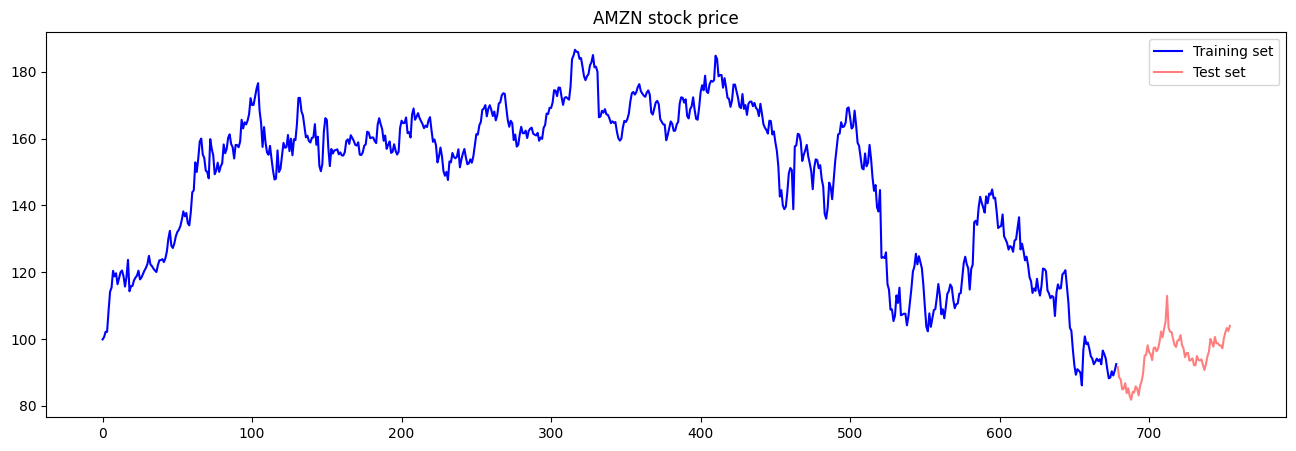

In [32]:
figure, axes = plt.subplots(figsize=(16,5))
axes.plot(training_set_pre['Close'], color='blue')
axes.plot(test_set_pre['Close'], color='red', alpha=0.5)
plt.legend([f'Training set',f'Test set'])
plt.title(f'{companyName} stock price')
plt.show()


In [149]:
training_set_pre.columns = ['start', 'target']
test_set_pre.columns = ['start', 'target']
training_set_pre['target'] = training_set_pre['target'].apply(lambda x: np.array([x]))
test_set_pre['target'] = test_set_pre['target'].apply(lambda x: np.array([x]))


In [151]:
#convert test and train dataframe to dataset for convienience
training_set = Dataset.from_pandas(training_set_pre)
test_set = Dataset.from_pandas(test_set_pre)

In [154]:
freq = "D"
prediction_length = 1 #as needed

convert the 'Datetime' feature of each time series to a pandas Period index using the data's freq:

In [155]:
def convert_to_pandas_period(date, freq):
    return pd.Period(date, freq)

def transform_start_field(batch, freq):
    batch['start'] = [convert_to_pandas_period(date, freq) for date in batch['start']]
    #batch['start'] = [date.to_period(freq) for date in batch['start']]
    return batch

Update datetime to pd.Period

In [156]:
training_set.set_transform(partial(transform_start_field, freq=freq))
test_set.set_transform(partial(transform_start_field, freq=freq))

lags for a given frequency: these specify how much we "look back", to be added as additional features. e.g. for a Daily frequency we might consider a look back of [1, 2, 7, 30, ...] or in other words look back 1, 2, ... days

In [157]:
lags_sequence = get_lags_for_frequency(freq)
print(lags_sequence)

[1, 2, 3, 4, 5, 6, 7, 8, 13, 14, 15, 20, 21, 22, 27, 28, 29, 30, 31, 56, 84, 363, 364, 365, 727, 728, 729, 1091, 1092, 1093]


In [158]:
time_features = time_features_from_frequency_str(freq)
print(time_features)

[<function day_of_week at 0x0000025762CF11B0>, <function day_of_month at 0x0000025762CF12D0>, <function day_of_year at 0x0000025762CF13F0>]


In [159]:
config = TimeSeriesTransformerConfig(
    # prediction_length: this is the horizon that the decoder of the Transformer will learn to predict for
    prediction_length=prediction_length,
    # context length: the model will set the context_length (input of the encoder) equal to the prediction_length, if no context_length is specified
    context_length=8,
    # lags coming from helper given the freq:
    lags_sequence=lags_sequence,
    # we'll add 3 time features (above and age feature):
    num_time_features=len(time_features) + 1,
    # we have a single static categorical feature, namely time series ID: amzn
    num_static_categorical_features=0, #used to be 1
    num_static_real_features = 0,
    num_dynamic_real_features = 0,
    # it has 679 possible values:
    cardinality=[len(training_set)],
    # the model will learn an embedding of size for each of the 679 possible values:
    embedding_dimension=[2],
    
    # transformer params:
    encoder_layers=4,
    decoder_layers=4,
    d_model=32,
)

model = TimeSeriesTransformerForPrediction(config)

In [160]:
model.config.distribution_output

'student_t'

In [164]:
def create_transformation(freq: str, config: PretrainedConfig) -> Transformation:
    remove_field_names = []
    if config.num_static_real_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_REAL)
    if config.num_dynamic_real_features == 0:
        remove_field_names.append(FieldName.FEAT_DYNAMIC_REAL)
    if config.num_static_categorical_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_CAT)

    # a bit like torchvision.transforms.Compose
    return Chain(
        # step 1: remove static/dynamic fields if not specified
        [RemoveFields(field_names=remove_field_names)]
        # step 2: convert the data to NumPy (potentially not needed)
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_CAT,
                    expected_ndim=1,
                    dtype=int,
                )
            ]
            if config.num_static_categorical_features > 0
            else []
        )
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_REAL,
                    expected_ndim=1,
                )
            ]
            if config.num_static_real_features > 0
            else []
        )
        + [
            AsNumpyArray(
                field=FieldName.TARGET,
                # we expect an extra dim for the multivariate case:
                expected_ndim=1, # if config.input_size == 1 else 2,
            ),
            # step 3: handle the NaN's by filling in the target with zero
            # and return the mask (which is in the observed values)
            # true for observed values, false for nan's
            # the decoder uses this mask (no loss is incurred for unobserved values)
            # see loss_weights inside the xxxForPrediction model
            AddObservedValuesIndicator(
                target_field=FieldName.TARGET,
                output_field=FieldName.OBSERVED_VALUES,
            ),
            # step 4: add temporal features based on freq of the dataset
            # 3 feats in the case when freq="d"
            # these serve as positional encodings
            AddTimeFeatures(
                start_field=FieldName.START,
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_TIME,
                time_features=time_features_from_frequency_str(freq),
                pred_length=config.prediction_length,
            ),
            # step 5: add another temporal feature (just a single number)
            # tells the model where in its life the value of the time series is,
            # sort of a running counter
            AddAgeFeature(
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_AGE,
                pred_length=config.prediction_length,
                log_scale=True,
            ),
            # step 6: vertically stack all the temporal features into the key FEAT_TIME
            VstackFeatures(
                output_field=FieldName.FEAT_TIME,
                input_fields=[FieldName.FEAT_TIME, FieldName.FEAT_AGE]
                + (
                    [FieldName.FEAT_DYNAMIC_REAL]
                    if config.num_dynamic_real_features > 0
                    else []
                ),
            ),
            # step 7: rename to match HuggingFace names
            RenameFields(
                mapping={
                    FieldName.FEAT_STATIC_CAT: "static_categorical_features",
                    FieldName.FEAT_STATIC_REAL: "static_real_features",
                    FieldName.FEAT_TIME: "time_features",
                    FieldName.TARGET: "values",
                    FieldName.OBSERVED_VALUES: "observed_mask",
                }
            ),
        ]
    )

In [165]:
def create_instance_splitter(
    config: PretrainedConfig,
    mode: str,
    train_sampler: Optional[InstanceSampler] = None,
    validation_sampler: Optional[InstanceSampler] = None,
) -> Transformation:
    assert mode in ["train", "validation", "test"]

    instance_sampler = {
        "train": train_sampler
        or ExpectedNumInstanceSampler(
            num_instances=1.0, min_future=config.prediction_length
        ),
        "validation": validation_sampler
        or ValidationSplitSampler(min_future=config.prediction_length),
        "test": TestSplitSampler(),
    }[mode]

    return InstanceSplitter(
        target_field="values",
        is_pad_field=FieldName.IS_PAD,
        start_field=FieldName.START,
        forecast_start_field=FieldName.FORECAST_START,
        instance_sampler=instance_sampler,
        past_length=config.context_length + max(config.lags_sequence),
        future_length=config.prediction_length,
        time_series_fields=["time_features", "observed_mask"],
    )

In [166]:
def create_train_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    num_batches_per_epoch: int,
    shuffle_buffer_length: Optional[int] = None,
    cache_data: bool = True,
    **kwargs,
) -> Iterable:
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    TRAINING_INPUT_NAMES = PREDICTION_INPUT_NAMES + [
        "future_values",
        "future_observed_mask",
    ]

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=True)
    if cache_data:
        transformed_data = Cached(transformed_data)

    # we initialize a Training instance
    instance_splitter = create_instance_splitter(config, "train")

    # the instance splitter will sample a window of
    # context length + lags + prediction length (from the 366 possible transformed time series)
    # randomly from within the target time series and return an iterator.
    stream = Cyclic(transformed_data).stream()
    training_instances = instance_splitter.apply(stream)
    
    return as_stacked_batches(
        training_instances,
        batch_size=batch_size,
        shuffle_buffer_length=shuffle_buffer_length,
        field_names=TRAINING_INPUT_NAMES,
        output_type=torch.tensor,
        num_batches_per_epoch=num_batches_per_epoch,
    )

In [167]:
def create_backtest_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    **kwargs,
):
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data)

    # we create a Validation Instance splitter which will sample the very last
    # context window seen during training only for the encoder.
    instance_sampler = create_instance_splitter(config, "validation")

    # we apply the transformations in train mode
    testing_instances = instance_sampler.apply(transformed_data, is_train=True)
    
    return as_stacked_batches(
        testing_instances,
        batch_size=batch_size,
        output_type=torch.tensor,
        field_names=PREDICTION_INPUT_NAMES,
    )

In [168]:
def create_test_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    **kwargs,
):
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=False)

    # We create a test Instance splitter to sample the very last
    # context window from the dataset provided.
    instance_sampler = create_instance_splitter(config, "test")

    # We apply the transformations in test mode
    testing_instances = instance_sampler.apply(transformed_data, is_train=False)
    
    return as_stacked_batches(
        testing_instances,
        batch_size=batch_size,
        output_type=torch.tensor,
        field_names=PREDICTION_INPUT_NAMES,
    )

train_dataloader = create_train_dataloader(
    config=config,
    freq=freq,
    data=training_set,
    batch_size=256,
    num_batches_per_epoch=100,
)

test_dataloader = create_backtest_dataloader(
    config=config,
    freq=freq,
    data=test_set,
    batch_size=64,
)

In [169]:
batch = next(iter(train_dataloader))
for k, v in batch.items():
    print(k, v.shape, v.type())

past_time_features torch.Size([256, 1101, 4]) torch.FloatTensor
past_values torch.Size([256, 1101]) torch.FloatTensor
past_observed_mask torch.Size([256, 1101]) torch.FloatTensor
future_time_features torch.Size([256, 1, 4]) torch.FloatTensor
future_values torch.Size([256, 1]) torch.FloatTensor
future_observed_mask torch.Size([256, 1]) torch.FloatTensor


In [172]:
outputs = model(
    past_values=batch["past_values"],
    past_time_features=batch["past_time_features"],
    past_observed_mask=batch["past_observed_mask"],
    static_categorical_features=batch["static_categorical_features"]
    if config.num_static_categorical_features > 0
    else None,
    static_real_features=batch["static_real_features"]
    if config.num_static_real_features > 0
    else None,
    future_values=batch["future_values"],
    future_time_features=batch["future_time_features"],
    future_observed_mask=batch["future_observed_mask"],
    output_hidden_states=True,
)

In [173]:
print("Loss:", outputs.loss.item())

Loss: 81.58540344238281


In [174]:
accelerator = Accelerator()
device = accelerator.device

model.to(device)
optimizer = AdamW(model.parameters(), lr=6e-4, betas=(0.9, 0.95), weight_decay=1e-1)

model, optimizer, train_dataloader = accelerator.prepare(
    model,
    optimizer,
    train_dataloader,
)

model.train()
for epoch in range(40):
    for idx, batch in enumerate(train_dataloader):
        optimizer.zero_grad()
        outputs = model(
            static_categorical_features=batch["static_categorical_features"].to(device)
            if config.num_static_categorical_features > 0
            else None,
            static_real_features=batch["static_real_features"].to(device)
            if config.num_static_real_features > 0
            else None,
            past_time_features=batch["past_time_features"].to(device),
            past_values=batch["past_values"].to(device),
            future_time_features=batch["future_time_features"].to(device),
            future_values=batch["future_values"].to(device),
            past_observed_mask=batch["past_observed_mask"].to(device),
            future_observed_mask=batch["future_observed_mask"].to(device),
        )
        loss = outputs.loss

        # Backpropagation
        accelerator.backward(loss)
        optimizer.step()

        if idx % 100 == 0:
            print(loss.item())

81.20977783203125
67.66482543945312
63.26602554321289
60.178733825683594
57.996788024902344
57.767906188964844
56.8301887512207
55.358673095703125
55.323604583740234
55.151100158691406
54.12670135498047
53.73202896118164
54.078495025634766
53.485877990722656
52.548431396484375
53.16008758544922
54.52568435668945
54.30415344238281
52.22051239013672
52.392478942871094
51.64572525024414
51.272117614746094
51.894351959228516
51.52653121948242
50.64686584472656
53.008880615234375
52.996551513671875
50.46698760986328
50.625244140625
50.960166931152344
50.3216552734375
49.86559295654297
50.61317825317383
50.35539245605469
49.46671676635742
50.06959915161133
50.180641174316406
49.450828552246094
51.420047760009766
51.88180160522461


In [190]:
model.eval()

forecasts = []

for batch in test_dataloader:
    outputs = model.generate(
        static_categorical_features=batch["static_categorical_features"].to(device)
        if config.num_static_categorical_features > 0
        else None,
        static_real_features=batch["static_real_features"].to(device)
        if config.num_static_real_features > 0
        else None,
        past_time_features=batch["past_time_features"].to(device),
        past_values=batch["past_values"].to(device),
        future_time_features=batch["future_time_features"].to(device),
        past_observed_mask=batch["past_observed_mask"].to(device),
    )
    forecasts.append(outputs.sequences.cpu().numpy())

In [209]:
forecasts = np.vstack(forecasts)
print(forecasts.shape)

(76, 100, 1)


76

In [210]:
for item_id, ts in enumerate(test_set):
    training_data = ts["target"][:-prediction_length]
    ground_truth = ts["target"][-prediction_length:]
    print(training_data)

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]


In [184]:
mase_metric = load("evaluate-metric/mase")
smape_metric = load("evaluate-metric/smape")

forecast_median = np.median(forecasts, 1)

mase_metrics = []
smape_metrics = []
for item_id, ts in enumerate(test_set):
    training_data = ts["target"]#[:-prediction_length]
    ground_truth = ts["target"]#[-prediction_length:]
    mase = mase_metric.compute(
        predictions=forecast_median[item_id], 
        references=np.array(ground_truth), 
        training=np.array(training_data), 
        periodicity=get_seasonality(freq))
    mase_metrics.append(mase["mase"])
    
    smape = smape_metric.compute(
        predictions=forecast_median[item_id], 
        references=np.array(ground_truth), 
    )
    smape_metrics.append(smape["smape"])

ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

In [170]:
accelerator = Accelerator()
device = accelerator.device

model.to(device)
optimizer = AdamW(model.parameters(), lr=6e-4, betas=(0.9, 0.95), weight_decay=1e-1)

model, optimizer, train_dataloader = accelerator.prepare(
    model,
    optimizer,
    train_dataloader,
)

In [171]:
model.train()
for epoch in range(3):
    for idx, batch in enumerate(train_dataloader):
        optimizer.zero_grad()
        outputs = model(
            static_categorical_features=batch["static_categorical_features"].to(device)
            if config.num_static_categorical_features > 0
            else None,
            static_real_features=batch["static_real_features"].to(device)
            if config.num_static_real_features > 0
            else None,
            past_time_features=batch["past_time_features"].to(device),
            past_values=batch["past_values"].to(device),
            future_time_features=batch["future_time_features"].to(device),
            future_values=batch["future_values"].to(device),
            past_observed_mask=batch["past_observed_mask"].to(device),
            future_observed_mask=batch["future_observed_mask"].to(device),
        )
        loss = outputs.loss

        # Backpropagation
        accelerator.backward(loss)
        optimizer.step()

        if idx % 100 == 0:
            print(loss.item())

86.46857452392578


KeyboardInterrupt: 